In [1]:
# Loading data: Our data loaders are defined below after Intermediate and Output Blocks
# Adding the code snippet from there for review


# train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
# test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Note: This is not to be run; this is just for easily seeing the data loader. It is defined and used in later cells 

In [2]:
!pip install torch
!pip install torchvision

In [3]:
# Necessary Imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

In [4]:
# Intermediate Block
# Takes an image as an input. Passes it through L(num_layers) convolutional layers 
'''
in_channels : Num of channels as input
out_channels : Num of channels in the output image
num_layers : Num of convolutional layers
'''
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, kernel_size=3, stride=1, padding=1):
        super(IntermediateBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_layers = num_layers
        self.fc = nn.Linear(in_channels, num_layers)

        # Improved dropout usage and added more batch normalization
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Dropout(p=0.5)  # Increased dropout
            ) for _ in range(num_layers)
        ])

    def forward(self, x):
        m = x.mean([2, 3])
        a = self.fc(m)
        a = torch.softmax(a, dim=1)
        x_prime = 0
        for i, conv in enumerate(self.convs):
            conv_x = conv(x)
            weighted_conv_x = conv_x * a[:, i].view(-1, 1, 1, 1)
            x_prime += weighted_conv_x
        return x_prime


In [5]:
# Output block takes the output of last intermediate block and outputs a logits vector o
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.fc1 = nn.Linear(in_channels, num_classes)
        
    def forward(self, x):
        # Feed forward definition of output block
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        o = self.fc1(x)
        return o

In [6]:
# Customer classifer to call intermediate blocks and the output block

class CIFAR10Classifier(nn.Module):
    def __init__(self, in_channel=3, conv_layers=3):
        super(CIFAR10Classifier, self).__init__()
        
        # Intermediate Block Params are defined below
        # IntermediateBlock(in_channel, out_channel, convolution_layer, kernel_size, stride, padding))

        # Intermediate blocks and their params are defined below. Currently using 3 blocks
        self.IntermediateBlocks = nn.ModuleList()
        
        self.IntermediateBlocks.append(IntermediateBlock(in_channel, 32, conv_layers, kernel_size=3, stride=1, padding=1))
        self.IntermediateBlocks.append(IntermediateBlock(32, 64, conv_layers, kernel_size=3, stride=1, padding=1))
        self.IntermediateBlocks.append(IntermediateBlock(64, 128, conv_layers, kernel_size=3, stride=1, padding=1))
        
        # Output block takes the output from intermediate block
        self.output_block = OutputBlock(128, 10)

    def forward(self, x):
        # Pass input through each intermediate block sequentially
        for block in self.IntermediateBlocks:
            x = block(x)
        # Final output block
        x = self.output_block(x)
        return x


In [7]:
# Handle GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Instantiating the model
model = CIFAR10Classifier()
model = model.to(device)

# Hyperparameters
batch_size = 128
learning_rate = 0.001
epochs = 100

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Transformations for training and test set
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),  # Rotate images by up to 10 degrees
    # transforms.RandomCrop(32, padding=4),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Loading the data using CIFAR-10 and above transformations
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Defining scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=0.3)


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Printing Model
model

CIFAR10Classifier(
  (IntermediateBlocks): ModuleList(
    (0): IntermediateBlock(
      (fc): Linear(in_features=3, out_features=3, bias=True)
      (convs): ModuleList(
        (0-2): 3 x Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.5, inplace=False)
        )
      )
    )
    (1): IntermediateBlock(
      (fc): Linear(in_features=32, out_features=3, bias=True)
      (convs): ModuleList(
        (0-2): 3 x Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.5, inplace=False)
        )
      )
    )
    (2): IntermediateBlock(
      (fc): Linear(in_features=64, out_features=3, bias=True)
      (convs): ModuleList(


In [9]:
# Training loop

training_set_accuracy = []
test_set_accuracy = []
training_loss = []
testing_loss = []

def train(model, train_loader, criterion, optimizer, device):
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total = 0
        correct = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            # Fetching predicted labels
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            lr = optimizer.param_groups[0]['lr']

        scheduler.step()

        # Calculating accuracy and training loss
        curr_train_accuracy = 100 * correct / total
        training_set_accuracy.append(curr_train_accuracy)
        train_loss = total_loss / len(train_loader)
        training_loss.append(train_loss)


        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                total_loss += loss.item()

        # Calculating test accuracy and loss
        test_accuracy = 100 * correct / total
        test_set_accuracy.append(test_accuracy)
        test_loss = total_loss/ len(test_loader)
        testing_loss.append(test_loss)


        print(f'Epoch {epoch+1} of {epochs}, Train Accuracy: {curr_train_accuracy}, Loss: {train_loss}, Test Accuracy: {test_accuracy}, Learning Rate: {lr}')

# Calling the training model
train(model, train_loader, criterion, optimizer, device)


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1 of 100, Train Accuracy: 35.212, Loss: 1.7917681484271193, Test Accuracy: 38.25, Learning Rate: 0.0003999999999999993
Epoch 2 of 100, Train Accuracy: 46.736, Loss: 1.4926759452771043, Test Accuracy: 48.81, Learning Rate: 0.0004000001721825002
Epoch 3 of 100, Train Accuracy: 50.988, Loss: 1.374124060506406, Test Accuracy: 46.29, Learning Rate: 0.0004000006887299925
Epoch 4 of 100, Train Accuracy: 53.798, Loss: 1.3040612009175294, Test Accuracy: 52.49, Learning Rate: 0.0004000015496424345
Epoch 5 of 100, Train Accuracy: 55.564, Loss: 1.2568135078605789, Test Accuracy: 56.49, Learning Rate: 0.00040000275491976905
Epoch 6 of 100, Train Accuracy: 56.782, Loss: 1.2148174375219418, Test Accuracy: 54.44, Learning Rate: 0.0004000043045619076
Epoch 7 of 100, Train Accuracy: 58.116, Loss: 1.1800186242288946, Test Accuracy: 54.14, Learning Rate: 0.00040000619856874094
Epoch 8 of 100, Train Accuracy: 59.014, Loss: 1.1549683746779362, Test Accuracy: 56.66, Learning Rate: 0.0004000084369401302

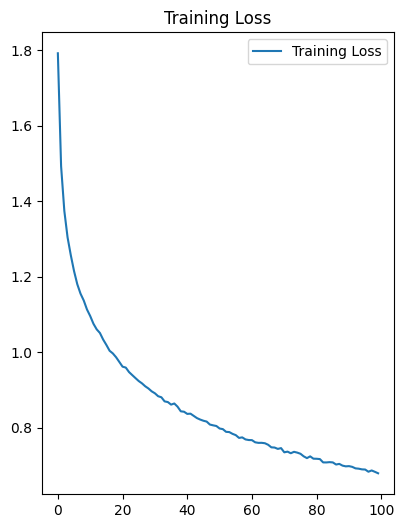

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()


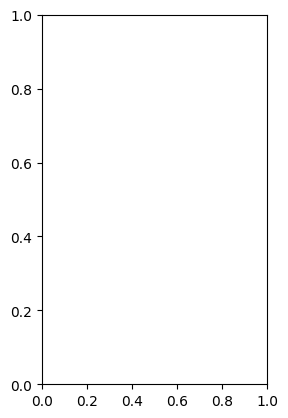

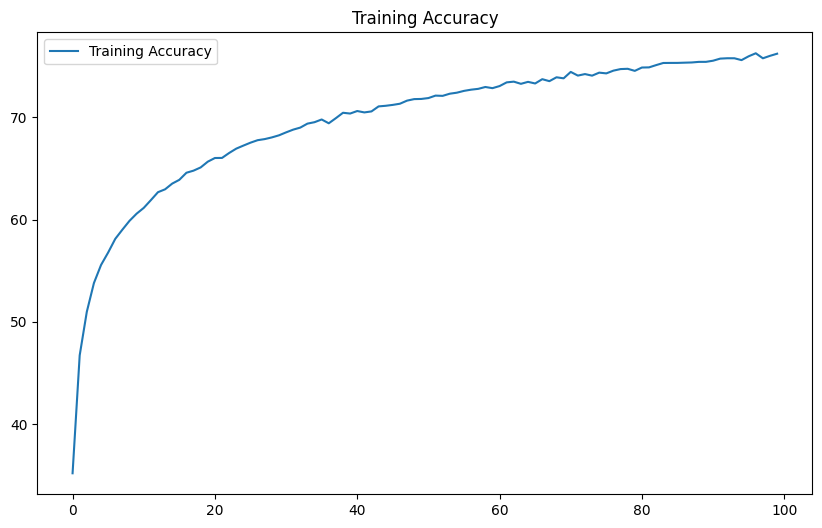

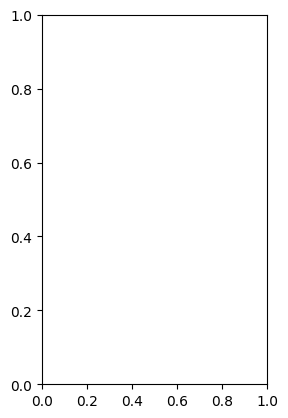

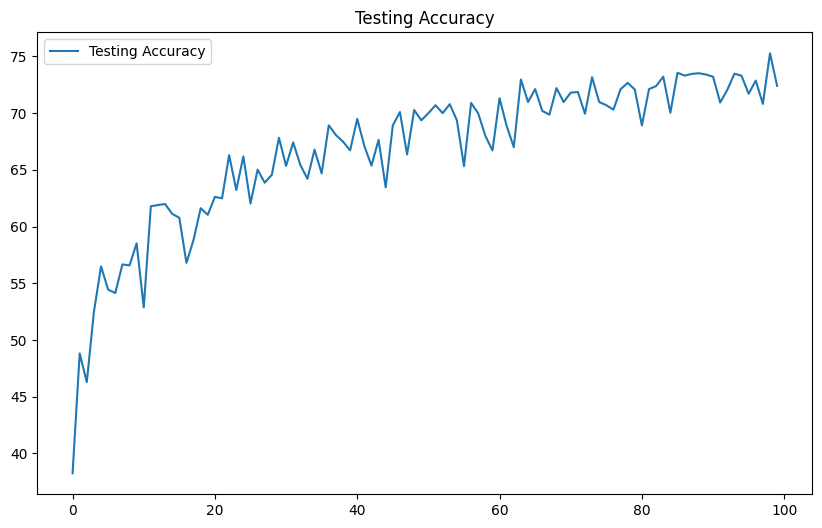

In [23]:
plt.subplot(1, 2, 2)
plt.figure(figsize=(10, 6))
plt.plot(training_set_accuracy, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 2)
plt.plot(test_set_accuracy, label='Testing Accuracy')
plt.title('Testing Accuracy')
plt.legend()
plt.show()


In [10]:
# Testing loop
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total}%')

test(model, test_loader, device)

Accuracy: 72.41%
